# Map Generator

In [1]:
#This script is used to generate any type of flow map (as function of the superficial velocities)
#The parameters can be set below, the units of measure are specified in the comments on the right of each line

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

In [2]:
#Creating a log spaced set of points:
liquid = 10.**(np.arange(-3, 1))
gas = 10.**(np.arange(-2, 2))
a2 = np.arange(1,10,0.1)
a3 = np.arange(1,10,0.1)

In [3]:
length = np.outer(liquid, a2).flatten()
height = np.outer(gas, a3).flatten()

In [4]:
mapping=[]
for i in length:
    for j in height:
        mapping.append([i, j])
    
final_test = pd.DataFrame(mapping, columns=['Vsl','Vsg'])    

# Parameters settings and Net loading

In [5]:
P = np.full(len(mapping), 101) #KPa
T = np.full(len(mapping), 25) #°C
DenL = np.full(len(mapping), 1000) #Kg/m^3
DenG = np.full(len(mapping), 1.2) #Kg/m^3
VisL = np.full(len(mapping), 0.001) #Pa*s
ST = np.full(len(mapping), 0.07) #N/m
ID = np.full(len(mapping), 0.0254) #m
Ang= np.full(len(mapping), 0) #Degree

In [6]:
preprocess = pd.DataFrame([P, T, DenL, DenG, VisL, ST, ID, Ang]).transpose()
preprocess.columns =['P','T', 'DenL', 'DenG', 'VisL', 'ST','ID', 'Ang']

In [7]:
df_map = pd.concat([preprocess,final_test], axis=1)

In [8]:
#We operate on the CPU beacuse we can't do better given the dataset size, if expanded, try change this to "cuda"
device = torch.device("cpu")

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Input = Multiphase flow properties Output =  neurons
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 5)
    
    def forward(self, x):
        #Activation function in F.relu (rectified linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1, )

In [10]:
net = Net().to(device)
checkpoint = torch.load('./NNKLD.pth', map_location='cpu')
net.load_state_dict(checkpoint['net_state_dict'])
net.eval()

Net(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

# Normalization and Evaluation

In [11]:
#This dataset is raw, we can however we have the normalizing constants from the preprocessing script
normalizing = pd.read_csv('Data/Normalizing.csv')
#We take every element of the df and normalize them:
val_n = np.zeros([df_map.shape[0], df_map.shape[1]])
for isig in range(df_map.shape[1]):
    val_n[:,isig]=(df_map.iloc[:,isig]-normalizing.iloc[isig,0])/normalizing.iloc[isig,1]
    
df_test = pd.DataFrame(val_n, columns=['P','T', 'DenL', 'DenG', 'VisL', 'ST','ID', 'Ang','Vsl', 'Vsg'])

In [12]:
X_old = np.array(df_test)
X_validation = torch.Tensor(X_old)
predicted = []
for i in range(0, len(X_validation)):
    net_out = net(X_validation[[i]])
    predicted.append(torch.argmax(net_out).item())

In [13]:
Total = pd.concat([df_map, pd.DataFrame(predicted, columns=['Predicted'])],axis=1)

# The Map

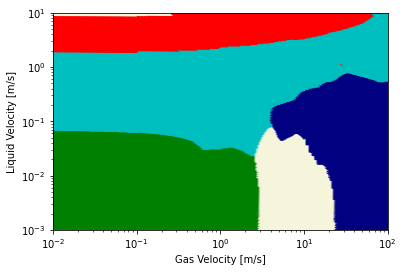

In [14]:
Y_map = np.array(Total['Vsl'])
X_map = np.array(Total['Vsg'])
categories = Total['Predicted']
#Dict = {red:'Dispersed Bubble', green:'Stratifeid Smoth', beige:'Stratified Wavy', navy:'Annular', cyan:'Intermittent'} 
colormap = np.array(['r', 'g', 'beige', 'navy', 'c'])
c=colormap[categories]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, facecolor='None')
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(X_map, Y_map, s=40, c=colormap[categories], edgecolors='none',alpha=0.9)

plt.xlim([0.01,100])
plt.ylim([0.001,10])

plt.xlabel('Gas Velocity [m/s]')
plt.ylabel('Liquid Velocity [m/s]')

plt.show()